# Model Building

In [1]:
import os
import requests
import zipfile
import tarfile
import hashlib
from sklearn.preprocessing import StandardScaler,PowerTransformer
#from google.colab import  drive
#drive.mount("/drive", force_remount=True)
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

from d2l import torch as d2l
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('Solarize_Light2')
%matplotlib inline

## Downloading data

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))
print(train_data.shape)
print(test_data.shape)
train_data['mod_yr_built'] = train_data.YrSold - train_data.YearRemodAdd
#train_data['log_LotFrontage'] = np.log(train_data.LotFrontage)
test_data['mod_yr_built'] = test_data.YrSold - test_data.YearRemodAdd

(1460, 81)
(1459, 80)


## Feature Engineering

In [3]:
numeric_features = ['GrLivArea','LowQualFinSF','2ndFlrSF','LotArea','mod_yr_built','FullBath','BedroomAbvGr','TotRmsAbvGrd',
                   'GarageArea','KitchenAbvGr','OverallQual','TotalBsmtSF','PoolArea','LotFrontage']
categorical_features = ['GarageQual','KitchenQual','MoSold','MSSubClass','MSZoning','SaleCondition','BldgType','HeatingQC','RoofStyle',
                        'ExterQual','Neighborhood','Condition1','BsmtQual','BsmtCond','BsmtFinType1','LandContour','Fence']
output_feature = ['SalePrice']
all_features = numeric_features + categorical_features + output_feature 

model_train_data = train_data.loc[:,all_features].copy()
 
model_train_data.loc[:,categorical_features] = model_train_data.loc[:,categorical_features].astype(str)
scaler_output = StandardScaler()
scaler_numerical = StandardScaler()

#scaler_output = PowerTransformer()
#scaler_numerical = PowerTransformer()

model_train_data.loc[:,output_feature] = scaler_output.fit_transform(train_data.loc[:,output_feature])
model_train_data.loc[:,numeric_features] = scaler_numerical.fit_transform(train_data.loc[:,numeric_features])
model_train_data = pd.get_dummies(model_train_data, dummy_na=False)

all_features_train_model =list(model_train_data.columns)
all_features_train_model.remove('SalePrice')


all_features_test = numeric_features + categorical_features
model_test_data = test_data.loc[:,all_features_test].copy()
model_test_data.loc[:,categorical_features] = model_test_data.loc[:,categorical_features].astype(str)
model_test_data.loc[:,numeric_features] = scaler_numerical.transform(test_data.loc[:,numeric_features])
model_test_data = pd.get_dummies(model_test_data, dummy_na=False)
all_features_test_model = list(model_test_data.columns)

train_feature_to_add = set(all_features_test_model).difference(set(all_features_train_model))
test_feature_to_add = set(all_features_train_model).difference(set(all_features_test_model))
for _f in train_feature_to_add:
    #print(_f)
    model_train_data[_f] = 0
    
for _f in test_feature_to_add:
    #print(_f)
    model_test_data[_f] = 0
    
all_features_model = list(model_test_data.columns)
model_train_data[numeric_features] = model_train_data[numeric_features].fillna(0)
if not(all(model_train_data.isna().sum() == 0)):
    print('Null Value present for train')
    print(model_train_data.columns[model_train_data.isnull().any()])
model_test_data[numeric_features] = model_test_data[numeric_features].fillna(0)
if not(all(model_test_data.isna().sum() == 0)):
    print('Null Value present for test')
    print(model_test_data.columns[model_test_data.isnull().any()])

In [4]:
train_features = torch.tensor(model_train_data.loc[:,all_features_model].values, dtype=torch.float32)
train_labels = torch.tensor(model_train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
test_features = torch.tensor(model_test_data.loc[:,all_features_model].values, dtype=torch.float32)

In [5]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
dropout1, dropout2 = 0.2, 0.5

def get_net():
    #net = nn.Sequential(nn.Linear(in_features, 256),nn.ReLU(), nn.Linear(256, 128),nn.ReLU(),nn.Linear(128, 64),nn.ReLU(),nn.Linear(64, 1))
    net = nn.Sequential(nn.Linear(in_features, 128),nn.ReLU(),nn.Linear(128, 64),nn.ReLU(),nn.Linear(64, 1))
    #net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [6]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    pred_output = torch.tensor(scaler_output.inverse_transform(net(features).detach().numpy()))
    clipped_preds = torch.clamp(pred_output, 1, float('inf'))
    inverted_labels = torch.tensor(scaler_output.inverse_transform(labels))
    loss = nn.MSELoss()
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(inverted_labels)))
    #print(clipped_preds[0],inverted_labels[0])
    return rmse.item()

In [7]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.SGD(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [8]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.106793, valid log rmse 0.125421
fold 2, train log rmse 0.101925, valid log rmse 0.152814
fold 3, train log rmse 0.103809, valid log rmse 0.135039
fold 4, train log rmse 0.104670, valid log rmse 0.126729
fold 5, train log rmse 0.105650, valid log rmse 0.155236
5-fold validation: avg train log rmse: 0.104569, avg valid log rmse: 0.139048


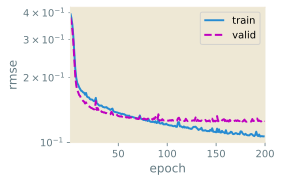

In [9]:
k, num_epochs, lr, weight_decay, batch_size = 5, 200, 0.01, 0.01, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [10]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = d2l.numpy(net(test_features))
    test_data['SalePrice'] = scaler_output.inverse_transform(preds)
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    return preds

train log rmse 0.105848


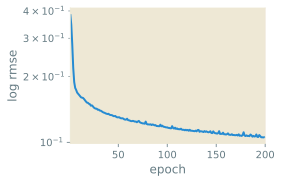

In [11]:
preds = train_and_pred(train_features, test_features, train_labels, test_data,num_epochs, lr, weight_decay, batch_size)

In [12]:
preds[np.isnan(preds)]

array([], dtype=float32)